In [1]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import cv2

In [ ]:
from huggingface_hub import login
from datasets import load_dataset

# Log in to your Hugging Face account

# Now try loading the dataset
ds = load_dataset("PeterBrendan/AdImageNet")

README.md:   0%|          | 0.00/3.68k [00:00<?, ?B/s]

(…)-00000-of-00002-6e587552aa3c8ac8.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

(…)-00001-of-00002-823ac5dae71e0e87.parquet:   0%|          | 0.00/338M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9003 [00:00<?, ? examples/s]

In [3]:
dataset=ds

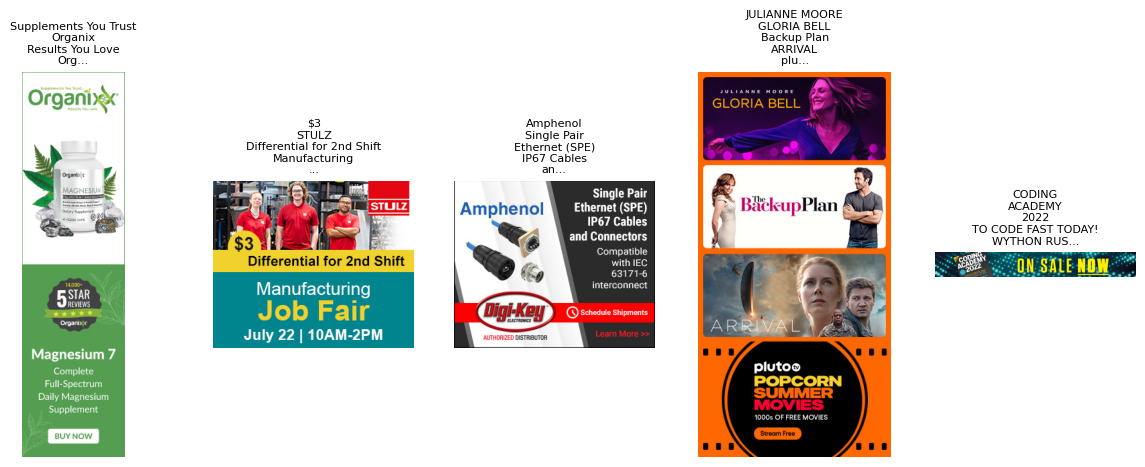

In [4]:
import matplotlib.pyplot as plt

def plot_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        sample = dataset['train'][i]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample['image'])
        plt.title(sample['text'][:50] + "...", fontsize=8)
        plt.axis('off')
    plt.show()

plot_samples(dataset)


In [5]:
import re

def clean_text(batch):
    batch['text'] = re.sub(r'\s+', ' ', batch['text']).strip()  # Supprime les espaces multiples
    batch['text'] = batch['text'].lower().capitalize()  # Normalisation de la casse
    batch['text'] = re.sub(r'[^\w\s.,!?-]', '', batch['text'])  # Nettoie les caractères spéciaux
    return batch

dataset = dataset.map(clean_text)

Map:   0%|          | 0/9003 [00:00<?, ? examples/s]

In [6]:

# Afficher quelques exemples de textes après nettoyage
for i in range(5):  # Afficher les 5 premiers exemples
    print(f"Texte original : {dataset['train'][i]['text']}")
    print("-----")

Texte original : Supplements you trust organix results you love organi magnesium iak dietary supplement 001 14,000 5 star reviews organixor magnesium 7 complete full-spectrum daily magnesium supplement buy now
-----
Texte original : 3 stulz differential for 2nd shift manufacturing job fair july 22  10am-2pm
-----
Texte original : Amphenol single pair ethernet spe ip67 cables and connectors compatible with iec 63171-6 interconnect digi-key schedule shipments learn more  authorized distributor
-----
Texte original : Julianne moore gloria bell backup plan arrival pluto popcorn summer movies 1000s of free movies stream free
-----
Texte original : Coding academy 2022 to code fast today! wython rusak on sale now
-----


In [7]:
from PIL import Image
import io

def resize_image(batch):
    img = batch['image']

    # Conversion nécessaire pour les datasets
    if isinstance(img, bytes):
        img = Image.open(io.BytesIO(img))

    # Redimensionnement et mise au format 512x512
    img = img.convert('RGB')
    img = img.resize((512, 512), Image.BILINEAR)

    batch['image'] = img
    return batch

dataset = dataset.map(resize_image, batched=False)

Map:   0%|          | 0/9003 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
# Afficher les nouvelles dimensions des images
for i in range(5):  # Afficher les 5 premières images pour vérifier
    print(f"Dimensions de l'image {i} : {dataset['train'][i]['image'].size}")

Dimensions de l'image 0 : (512, 512)
Dimensions de l'image 1 : (512, 512)
Dimensions de l'image 2 : (512, 512)
Dimensions de l'image 3 : (512, 512)
Dimensions de l'image 4 : (512, 512)


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'dimensions'],
        num_rows: 9003
    })
})

In [10]:
print(type(dataset))  # Vérifier le type du dataset



<class 'datasets.dataset_dict.DatasetDict'>


In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'dimensions'],
        num_rows: 9003
    })
})

In [12]:
import os
import pandas as pd
from PIL import Image

# Définition des chemins
dataset_dir = "midjourney-v0/midjourney-512px-v0"
images_dir = os.path.join(dataset_dir, "images")
csv_path = os.path.join(dataset_dir, "index.csv")

# Assurer que les dossiers existent
os.makedirs(images_dir, exist_ok=True)

# Liste pour stocker les métadonnées
metadata = []

# Accéder au split "train"
dataset_train = dataset["train"]

# Sauvegarder les images et les textes
for i, data in enumerate(dataset_train):
    image = data["image"]  # Image sous forme de PIL.Image
    text = data["text"]  # Texte descriptif

    # Nom du fichier image
    img_name = f"image_{i+1}.jpg"
    img_path = os.path.join(images_dir, img_name)

    # Sauvegarder l'image
    image.save(img_path, format="PNG")

    # Ajouter les infos dans la liste
    metadata.append({"image": img_name, "short_prompt": text})

# Convertir en DataFrame et sauvegarder en CSV
df = pd.DataFrame(metadata)
df.to_csv(csv_path, index=False)

print(f"✅ Dataset sauvegardé avec {len(dataset_train)} images dans {dataset_dir}.")


✅ Dataset sauvegardé avec 9003 images dans midjourney-v0/midjourney-512px-v0.


In [13]:
print("hello world")

hello world


In [14]:
%pip install diffusers
%pip install peft

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pathlib import Path
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import login
from peft import LoraConfig
import torch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft.utils import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers
from datasets import load_dataset
from functools import partial
from PIL import Image
from kaggle_secrets import UserSecretsClient
from torch.utils.data import Dataset
import pandas as pd
from pydantic import BaseModel
from diffusers.training_utils import compute_snr

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [17]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet

In [18]:
class MidjourneyDataset(Dataset):
    def __init__(self, data_dir: Path, tokenizer: CLIPTokenizer):
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "/kaggle/working/midjourney-v0/midjourney-512px-v0/index.csv")
        self.tokenizer = tokenizer
        
        self.train_tranforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.data_dir / "images" / self.df.iloc[idx]["image"]
        image = Image.open(image_path).convert("RGB")
        image = self.train_tranforms(image)

        input_ids = self.tokenizer(
            self.df.iloc[idx]["short_prompt"],
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}

In [19]:
def setup_models_for_training(model_name, rank: int=128):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    # freeze all weights
    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    # config LoRA
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    # set trainaible weights to float32
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.parameters()])]

In [20]:
class TrainingConfig(BaseModel):
    train_steps: int = 100
    lr: float = 1e-5
    batch_size: int = 4
    accumulation_steps: int = 2
    rank: int = 128
    max_grad_norm: float = 1.0
    pretrained_name: str = "runwayml/stable-diffusion-v1-5"
    data_dir: str = "/kaggle/working/midjourney-v0/midjourney-512px-v0"
    snr_gamma: float = -1
    seed: int = -1

In [21]:
def train(
    tokenizer: CLIPTokenizer, 
    text_encoder: CLIPTextModel, 
    vae: AutoencoderKL, 
    scheduler: DDPMScheduler, 
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    lora_params = get_lora_params(unet)

    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    # data set
    train_dataset = MidjourneyDataset(Path(config.data_dir), tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # optimizer
    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    epochs = math.ceil(config.train_steps / steps_per_epoch)

    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)

    scaler = torch.cuda.amp.GradScaler()

    # progress bar setup
    global_step = 0
    progress_bar = tqdm(
        range(config.train_steps),
        desc="Steps"
    )

    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if config.snr_gamma > 0:
                    # should converge faster with snr_gamma, however works well with unweighted mse
                    # https://arxiv.org/abs/2303.09556
                    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            global_step+=1
            scaler.scale(loss).backward()

            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())

            progress_bar.set_postfix({"loss": losses[-1]})
            if global_step / config.accumulation_steps >= config.train_steps:
                break
    
    return {
        "losses": losses
    }

In [22]:
try:
    # in case of rerun, to make sure we free up GPU before calling train
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass

config = TrainingConfig()
config.lr = 1e-5
config.rank = 62
config.train_steps = 1000
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

models = setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

<ipython-input-21-17843f4ee72f>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

configs: train_steps=1000 lr=1e-05 batch_size=4 accumulation_steps=2 rank=62 max_grad_norm=1.0 pretrained_name='runwayml/stable-diffusion-v1-5' data_dir='/kaggle/working/midjourney-v0/midjourney-512px-v0' snr_gamma=5.0 seed=42
epochs: 1
steps per epoch: 1126
total steps: 1000
accumulation steps: 2
total batch size: 8
lr: 8e-05


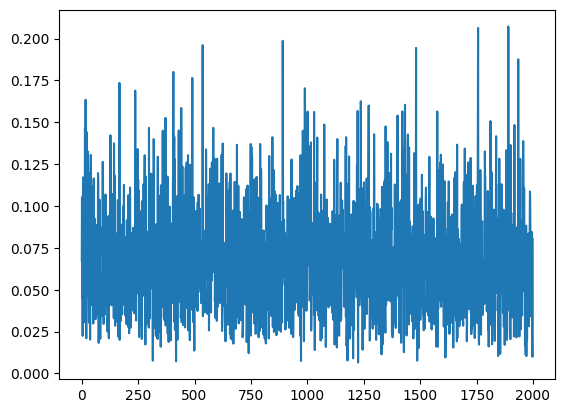

In [23]:
plt.plot(outputs["losses"])
plt.show()

In [24]:
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [25]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="./out",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

In [26]:
!ls -l -h ./out/pytorch_lora_weights.safetensors

-rw-r--r-- 1 root root 48M Mar 28 10:02 ./out/pytorch_lora_weights.safetensors


In [27]:
df = pd.read_csv(Path(config.data_dir) / "/kaggle/working/midjourney-v0/midjourney-512px-v0/index.csv")

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prompt_training = [df.iloc[0]["short_prompt"]]
prompt_new = "Unleash the joy of boating with Your Boat Club – unlimited access, unforgettable moments! Join today and start making memories that last a lifetime."
num_inference_steps=35
seed = 3

In [29]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

In [30]:
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

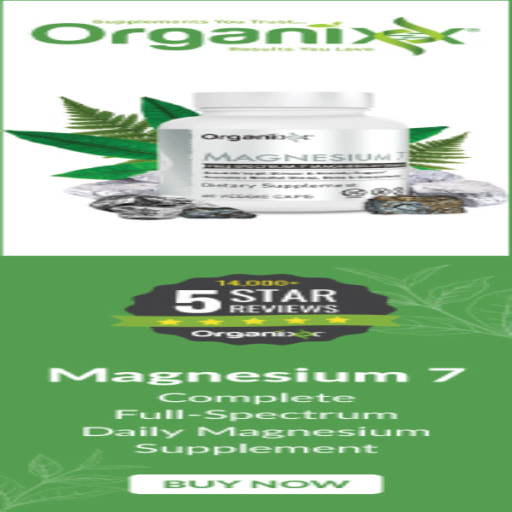

In [31]:
Image.open(Path(config.data_dir) / "images" / df.iloc[0]["image"])

  0%|          | 0/35 [00:00<?, ?it/s]

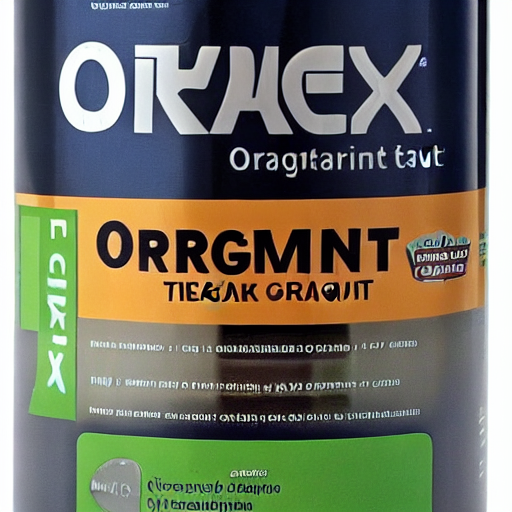

In [32]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

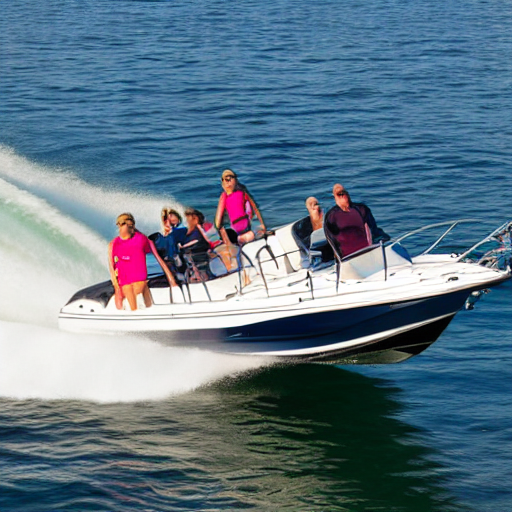

In [33]:
generate(pipe, prompt_new, seed)

In [34]:
pipe.load_lora_weights("./out/pytorch_lora_weights.safetensors")

  0%|          | 0/35 [00:00<?, ?it/s]

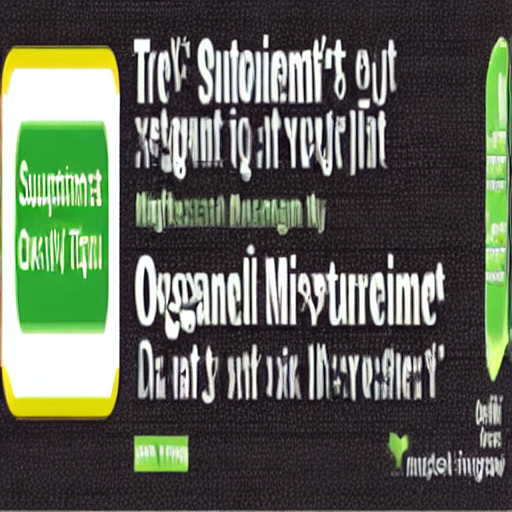

In [35]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

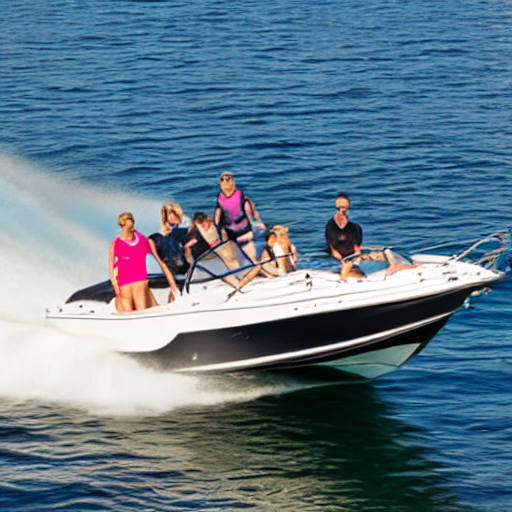

In [36]:
generate(pipe, prompt_new, seed)